In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
batch_size = 20

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


torch.Size([20, 3, 32, 32]) torch.Size([20])


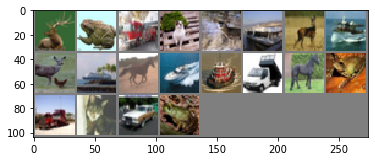

 deer  frog truck   cat  deer  ship  deer  ship  deer  ship horse  ship  ship truck horse  frog truck   cat   car  frog


In [0]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape, labels.shape)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [0]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
net.to(device)

summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

learning_rate = 0.03
optimizer = optim.Adagrad(net.parameters(), lr=learning_rate)

model = net
train_dataset = trainloader
total_epoch = 3

In [0]:
def get_prediction(output):
    return torch.argmax(output, axis=1)

def get_accuracy(pred, label):
    return torch.sum(pred == label).item() / len(label)

In [0]:
from tqdm import tqdm_notebook

def train(model, optimizer, criterion, train_dataset, total_epoch):
    for epoch in range(total_epoch):   # 데이터셋을 수차례 반복합니다.
        tbar = tqdm_notebook(train_dataset, 0)
        for i, data in enumerate(tbar):
            # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
            inputs, labels = data[0].to(device), data[1].to(device)

            # 변화도(Gradient) 매개변수를 0으로 만들고
            optimizer.zero_grad()

            # 순전파 + 역전파 + 최적화를 한 후
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # 통계를 출력합니다.
            running_loss = loss.item()
            if i % 10 == 9:    # print every 100 mini-batches
                pred = get_prediction(outputs)
                train_accuracy = get_accuracy(pred, labels)
                desc = 'epoch%d, loss: %.3f, accuracy: %.2f'%(epoch+1, running_loss, train_accuracy)
                tbar.set_description(desc)

    print('Finished Training')

In [0]:
train(model=model, optimizer=optimizer, criterion=criterion, train_dataset=train_dataset, total_epoch=total_epoch)


Finished Training


In [0]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

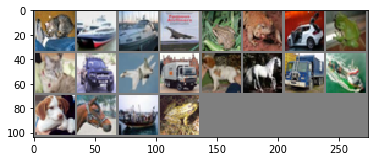

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog


In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [0]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [0]:
outputs = net(images)

In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

Predicted:    cat plane  ship plane  frog  frog   car  frog   cat   car  deer truck   cat horse truck  frog   dog   cat  ship  frog


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %
